In [1]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup
freyberg_setup.setup_pest_pp()
pst_name = freyberg_setup.PST_NAME_PP
working_dir = freyberg_setup.WORKING_DIR_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'obs_loc.csv', 'potobs_group.csv', 'Process_output.py', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_advanced_monte_carlo/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 


## Advanced Monte Carlo

In the previous pilot points Monte Carlo notebook, we saw that none of the realizations fit the observations anywhere close to ``phimlim`` because of the dimensionality of the pilot point problem.  Here, we will use so linear algebra trickeration to "pre-condition" the realizations so that they have a better chance of fitting the observations.  linear algebra = Jacobian!

### First we need to run the calibration process to get the MAP parameters and last Jacobian

In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
# some control settings
pst.control_data.noptmax = 8
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
# adjust observation weights
#wl_obs = [o for o in pst.nnz_obs_names if o.startswith('c')]
#pst.observation_data.loc[wl_obs,"weight"] = 0.5
# Tikhonov regularization
pyemu.helpers.zero_order_tikhonov(pst,par_groups=["rch","w0","w1"])
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
df_pp = pyemu.gw_utils.pp_tpl_to_dataframe(os.path.join(working_dir,"hkpp.dat.tpl"))
cov = gs.covariance_matrix(df_pp.x,df_pp.y,df_pp.parnme)
pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False)
pst.reg_data.phimlim = 500
pst.reg_data.phimaccept = 550
pst.control_data.pestmode = "regularization"
# subspace regularization
pst.svd_data.maxsing = 5
# save the control file and check it
pst.write(os.path.join(working_dir,pst_name))
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)


run():pestchek freyberg_pp.pst


In [4]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [5]:
obs = pst.observation_data
obs.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_river_l_19700102,flx_river_l_19700102,-3706.027000,0.1,calflux
cr03c10_19700102,cr03c10_19700102,22.331451,5.0,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,5.0,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,5.0,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,5.0,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,5.0,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,5.0,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,5.0,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,5.0,calhead


In [6]:
#pst.adjust_weights_resfile()
obs.loc[pst.nnz_obs_names,:]

,obsnme,obsval,weight,obgnme
obsnme,,,,
flx_river_l_19700102,flx_river_l_19700102,-3706.027000,0.1,calflux
cr03c10_19700102,cr03c10_19700102,22.331451,5.0,calhead
cr03c16_19700102,cr03c16_19700102,18.526869,5.0,calhead
cr04c09_19700102,cr04c09_19700102,24.412637,5.0,calhead
cr10c02_19700102,cr10c02_19700102,27.985834,5.0,calhead
cr14c11_19700102,cr14c11_19700102,21.070509,5.0,calhead
cr16c17_19700102,cr16c17_19700102,15.468176,5.0,calhead
cr22c11_19700102,cr22c11_19700102,20.485881,5.0,calhead
cr23c16_19700102,cr23c16_19700102,15.308345,5.0,calhead


In [7]:
pst.phi

530.1171125123047

## How does this all pan out when we run the models?

Let's look at two options:  
1. unconstrained Monte Carlo (like we did before [results were shitty!])  
2. posterior sampling from the ``schur`` compliment 

### first, unconstrained

In [8]:
cov = pyemu.helpers.geostatistical_prior_builder(pst,{gs:df_pp},sigma_range=6)
mc = pyemu.MonteCarlo(jco=os.path.join(working_dir,pst_name.replace(".pst",".jco")),pst=pst,parcov=cov)
mc.pst.parrep(os.path.join(working_dir,pst_name.replace(".pst",".parb")))
mc.draw(num_reals=500, enforce_bounds="reset",how='gaussian')
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.unconst.csv"))
pst.pestpp_options["sweep_output_csv_file"] = "sweep_out.unconst.csv"
pst.pestpp_options["sweep_parameter_csv_file"] = "sweep_in.unconst.csv"
pst.write(os.path.join(working_dir,pst_name))

In [9]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.','sweep',pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

master:sweep freyberg_pp.pst /h :4004 in .
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_14


### now with the ```schur``` bayesian monte carlo

Here, we will swap out the prior parameter covariance matrix ($\boldsymbol{\Sigma}_{\theta}$) for the FOSM-based posterior parameter covariance matrix ($\overline{\boldsymbol{\Sigma}}_{\theta}$).  Everything else is exactly the same (sounds like a NIN song)

In [10]:
sc = pyemu.Schur(jco=os.path.join(working_dir,pst_name.replace(".pst",".jcb")),pst=pst,parcov=cov)
sc.pst.parrep(os.path.join(working_dir,pst_name.replace(".pst",".parb")))
mc = pyemu.MonteCarlo(pst=pst,parcov=sc.posterior_parameter)
mc.draw(num_reals=500, enforce_bounds="reset",how='gaussian')
mc.parensemble.to_csv(os.path.join(working_dir,"sweep_in.schur.csv"))
pst.pestpp_options["sweep_output_csv_file"] = "sweep_out.schur.csv"
pst.pestpp_options["sweep_parameter_csv_file"] = "sweep_in.schur.csv"
pst.write(os.path.join(working_dir,pst_name))
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"sweep",pst_name,num_slaves=15,master_dir='.')
os.chdir("..")

master:sweep freyberg_pp.pst /h :4004 in .
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:sweep freyberg_pp.pst /h localhost:4004 in ../slave_14


unconstrained good enough:23
schur good enough:493


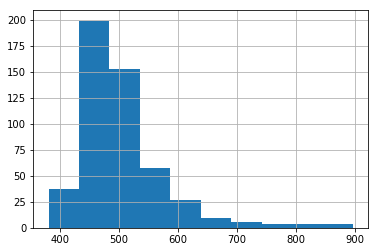

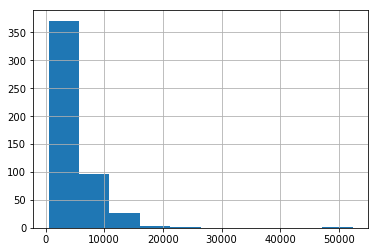

In [11]:
df_unconst = pd.read_csv(os.path.join(working_dir,"sweep_out.unconst.csv"))
df_unconst.columns = [c.lower() for c in df_unconst.columns]
df_schur = pd.read_csv(os.path.join(working_dir,"sweep_out.schur.csv"))
df_schur.columns = [c.lower() for c in df_schur.columns]

acceptable_phi = 800.0
ge_schur = df_schur.loc[df_schur.phi<acceptable_phi].index.values
ge_unconst = df_unconst.loc[df_unconst.phi<acceptable_phi].index.values
print("unconstrained good enough:{0}".format(len(ge_unconst)))    
print("schur good enough:{0}".format(len(ge_schur))) 
df_schur.phi.hist(bins=10)
plt.show()
df_unconst.phi.hist(bins=10)

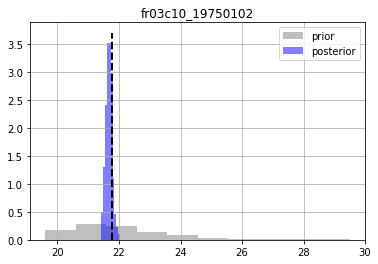

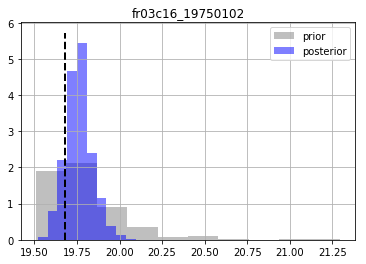

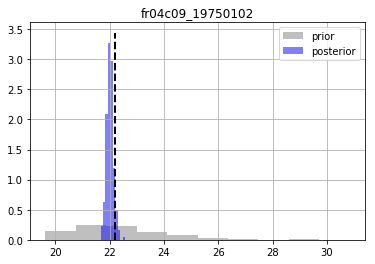

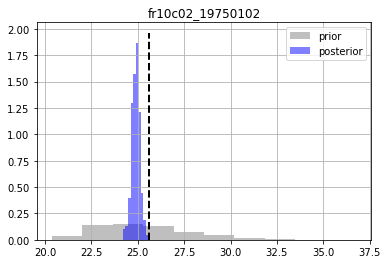

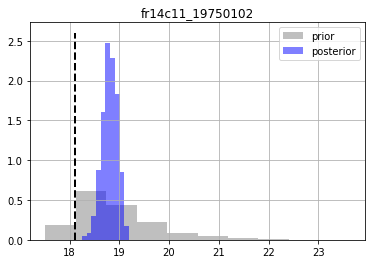

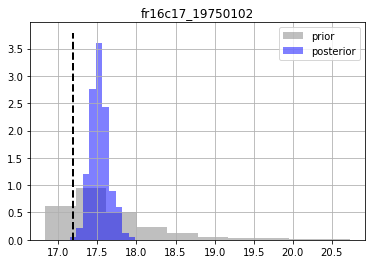

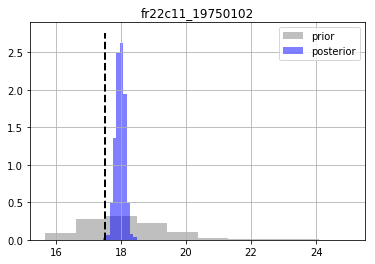

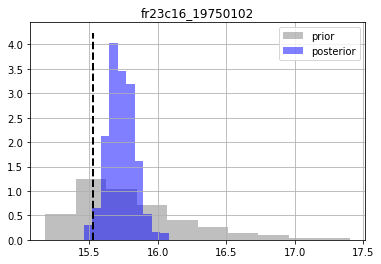

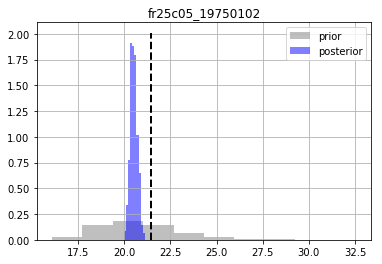

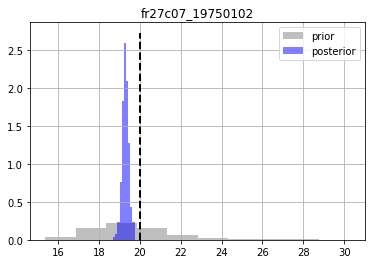

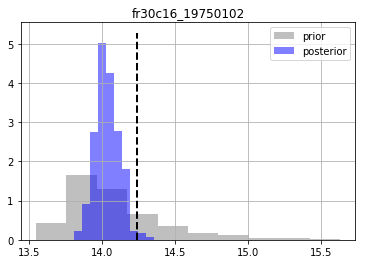

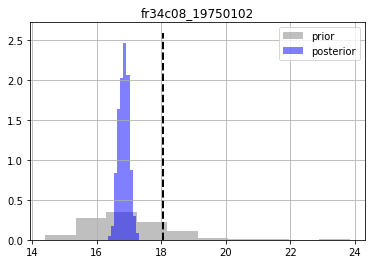

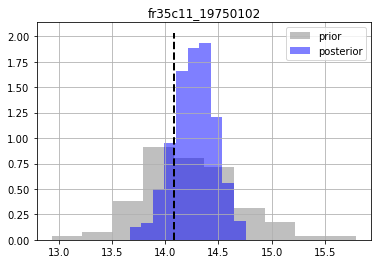

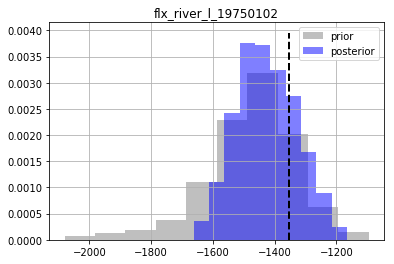

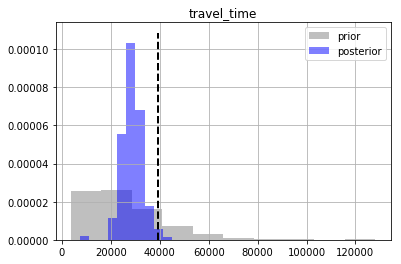

In [12]:
for forecast in mc.pst.forecast_names:
    ax = plt.subplot(111)
    df_unconst.loc[:,forecast].hist(ax=ax,bins=10,alpha=0.5,color="0.5",normed=True,label="prior") 
    df_schur.loc[ge_schur,forecast].hist(ax=ax,bins=10,alpha=0.5,color="b",normed=True,label="posterior")    
    ylim = ax.get_ylim()
    v = mc.pst.observation_data.loc[forecast,"obsval"]
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_title(forecast)
    ax.legend()
    plt.show()

We see that a fair number of realizations passed for the ``schur`` preconditioned case, while only a few passed from the unconstrainted draws from the prior. 

The good news...finally...we are bracketing the truth for most forecasts...whew! that's a lot of work.